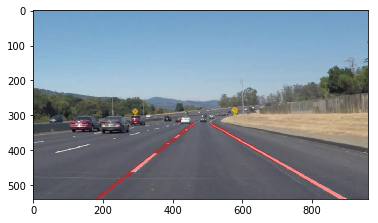

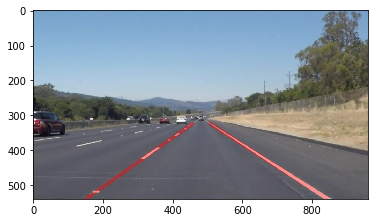

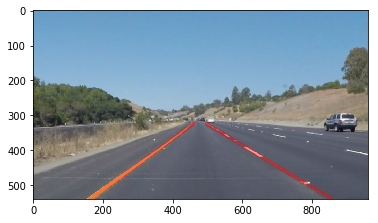

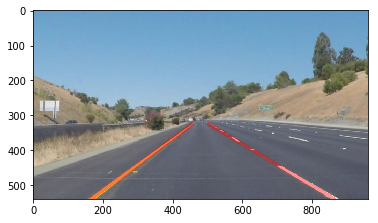

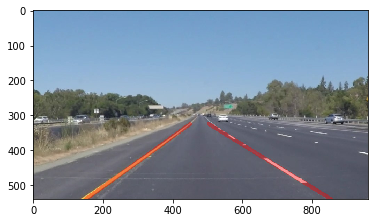

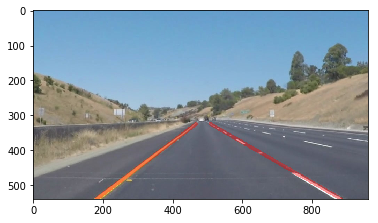

In [2]:
# Finding Lane Lines for Images
# import packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
import os
import math 
%matplotlib inline

# calculating average slope and intercept of a group of lines (seperate left and right)
# function inspired from //github.com/naokishibuya/car-finding-lane-lines
def findAvgLaneLines(lines):
    left_lines    = [] # (slope, intercept)
    left_length  = [] # (length)
    right_lines   = [] # (slope, intercept)
    right_length = [] # (length)
    for line in lines:
        for x1,y1,x2,y2 in line:
            if x1 == x2: #ignore vertical lines, slope not defined
                continue
            m = (y2-y1)/(x2-x1)
            b = y1-m*x1
            if (abs(m) < 0.5): #smooth out by removing lines close to horizontal
                continue
            length = math.sqrt(math.pow((y2-y1),2)+math.pow((x2-x1),2))
            if m < 0:
                left_lines.append((m,b))
                left_length.append((length))
            else:
                right_lines.append((m,b))
                right_length.append((length))
    #  based on length, give weight to longer lines 
    if len(left_length) > 0:
        left_lane  = np.dot(left_length,  left_lines) /np.sum(left_length)  
    else:
        left_lane = None
    if len(right_length) > 0:
        right_lane  = np.dot(right_length, right_lines)/np.sum(right_length)  
    else:
        right_lane = None

    return left_lane, right_lane # (slope, intercept), (slope, intercept)

# taking in lines and making 2 points
# function inspired from //github.com/naokishibuya/car-finding-lane-lines
def points_from_line(y1,y2,line):
    if line is None:
        return None
    
    m, b = line
    
    x1 = int((y1 - b)/m)
    x2 = int((y2 - b)/m)
    y1 = int(y1)
    y2 = int(y2)

    return ((x1, y1), (x2, y2))

# read each image in test_images
for filename in os.listdir("test_images/"):
    if filename.endswith(".jpg"): 
        # identify the image
        image = mpimg.imread(os.path.join("test_images/", filename))
        
        ## print original image and stats about the image (for testing)
        # print('This image ',filename,' is:', type(image), 'with dimesions:', image.shape)
        # plt.figure()
        # plt.imshow(image)
        
        # change image to greyscale
        gray = cv2.cvtColor(image,cv2.COLOR_RGB2GRAY)

        # define a kernel size and apply Gaussian smoothing
        kernel_size = 5
        blur_gray = cv2.GaussianBlur(gray,(kernel_size, kernel_size),0)
        
        # define parameters for Canny and apply
        low_threshold = 70
        high_threshold = 120
        edges = cv2.Canny(blur_gray, low_threshold, high_threshold)

        # create masked edges image using cv2.fillPoly()
        mask = np.zeros_like(edges)   
        ignore_mask_color = 255   

        # define four sided polygon to mask
        imshape = image.shape
        vertices = np.array([[(150,imshape[0]),(340, 330), (620, 330), (imshape[1]-50,imshape[0])]], dtype=np.int32)
        cv2.fillPoly(mask, vertices, ignore_mask_color)
        masked_edges = cv2.bitwise_and(edges, mask)

        # define the Hough transform parameters
        rho = 1 # distance resolution in pixels of the Hough grid
        theta = np.pi/180 # angular resolution in radians of the Hough grid
        threshold = 15     # minimum number of votes (intersections in Hough grid cell)
        min_line_length = 15  # minimum number of pixels making up a line
        max_line_gap = 15   # maximum gap in pixels between connectable line segments
        line_image = np.copy(image)*0 # creating a blank to draw lines on

        # run Hough on edge detected image
        # output "lines" is an array containing endpoints of detected line segments
        lines = cv2.HoughLinesP(masked_edges, rho, theta, threshold, np.array([]),
                                    min_line_length, max_line_gap)

        # iterate over the output "lines" and draw lines on a blank image
        for line in lines:
            for x1,y1,x2,y2 in line:
                cv2.line(line_image,(x1,y1),(x2,y2),(255,0,0),10)
        
        # create a "color" binary image to combine with line image
        color_edges = np.dstack((edges, edges, edges)) 

        # draw the lines on the edge image (for testing)
        lines_edges = cv2.addWeighted(color_edges, 0.8, line_image, 1, 0) 
        # plt.figure()
        # plt.imshow(lines_edges)


        # find average slope and y-intercept for lines
        avg_lane_lines = findAvgLaneLines(lines)
        
        # define the image for average lines and draw the average lines 
        overlay = image.copy()
        ybottom = imshape[0]
        ytop = 325
        points_left = points_from_line(ybottom, ytop, avg_lane_lines[0]) #((x1, y1), (x2, y2))
        points_right = points_from_line(ybottom, ytop, avg_lane_lines[1]) #((x1, y1), (x2, y2))
        cv2.line(overlay,points_left[0],points_left[1],(255,0,0),10)
        cv2.line(overlay,points_right[0],points_right[1],(255,0,0),10)
        
        # overlay the average lines over the original image with a transparent red color
        output = image.copy()
        cv2.addWeighted(overlay, 0.4, output, 0.6, 0, output)
        plt.figure()
        plt.imshow(output)
        
        # save the file as overlay
        mpimg.imsave((os.path.join("test_images/found_lane_lines/", filename)),output)
        
        


In [3]:
# Finding Lane Lines for Videos
# import packages
from moviepy.editor import VideoFileClip
from IPython.display import HTML

# process the image and overlay lane lines
def process_image(image):
    # change image to greyscale
    gray = cv2.cvtColor(image,cv2.COLOR_RGB2GRAY)

    # define a kernel size and apply Gaussian smoothing
    kernel_size = 5
    blur_gray = cv2.GaussianBlur(gray,(kernel_size, kernel_size),0)

    # define parameters for Canny and apply
    low_threshold = 80
    high_threshold = 120
    edges = cv2.Canny(blur_gray, low_threshold, high_threshold)

    # create masked edges image using cv2.fillPoly()
    mask = np.zeros_like(edges)   
    ignore_mask_color = 255   

    # define four sided polygon to mask
    imshape = image.shape
    vertices = np.array([[(150,imshape[0]),(340, 330), (620, 330), (imshape[1]-50,imshape[0])]], dtype=np.int32)
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    masked_edges = cv2.bitwise_and(edges, mask)

    # define the Hough transform parameters
    rho = 1 # distance resolution in pixels of the Hough grid
    theta = np.pi/180 # angular resolution in radians of the Hough grid
    threshold = 15     # minimum number of votes (intersections in Hough grid cell)
    min_line_length = 15  # minimum number of pixels making up a line
    max_line_gap = 15   # maximum gap in pixels between connectable line segments
    line_image = np.copy(image)*0 # creating a blank to draw lines on

    # run Hough on edge detected image
    # output "lines" is an array containing endpoints of detected line segments
    lines = cv2.HoughLinesP(masked_edges, rho, theta, threshold, np.array([]),
                                min_line_length, max_line_gap)

    # iterate over the output "lines" and draw lines on a blank image
    for line in lines:
        for x1,y1,x2,y2 in line:
            cv2.line(line_image,(x1,y1),(x2,y2),(255,0,0),10)

    # find average slope and y-intercept for lines
    avg_lane_lines = findAvgLaneLines(lines)

    # define the image for average lines and draw the average lines 
    overlay = image.copy()
    ybottom = imshape[0]
    ytop = 330
    points_left = points_from_line(ybottom, ytop, avg_lane_lines[0]) #((x1, y1), (x2, y2))
    points_right = points_from_line(ybottom, ytop, avg_lane_lines[1]) #((x1, y1), (x2, y2))
    if points_left is not None:
        cv2.line(overlay,points_left[0],points_left[1],(255,0,0),10)
        cv2.line(overlay,points_right[0],points_right[1],(255,0,0),10)

    # overlay the average lines over the original image with a transparent red color
    output = image.copy()
    processed = cv2.addWeighted(overlay, 0.4, output, 0.6, 0)
    return processed

white_output = 'white.mp4'
clip1 = VideoFileClip("solidWhiteRight.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

yellow_output = 'yellow.mp4'
clip2 = VideoFileClip('solidYellowLeft.mp4')
yellow_clip = clip2.fl_image(process_image)
%time yellow_clip.write_videofile(yellow_output, audio=False)


[MoviePy] >>>> Building video white.mp4
[MoviePy] Writing video white.mp4


100%|█████████▉| 221/222 [00:06<00:00, 32.41it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: white.mp4 

CPU times: user 3.02 s, sys: 1.38 s, total: 4.4 s
Wall time: 7.93 s
[MoviePy] >>>> Building video yellow.mp4
[MoviePy] Writing video yellow.mp4


100%|█████████▉| 681/682 [00:25<00:00, 26.68it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: yellow.mp4 

CPU times: user 9.9 s, sys: 4.18 s, total: 14.1 s
Wall time: 26.5 s
